## Importing Libraries

In [1]:
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage import morphology
import tensorflow as tf

In [2]:
path = "my_dataset/train/B-/2.jpg"

In [3]:
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [4]:
print(img)

[[252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]
 ...
 [252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]
 [252 252 252 ... 252 252 252]]


## Preprocessing

In [5]:
# Step 1: Ridge Segmentation (Edge Detection using Sobel)
def ridge_segmentation(img):
 # Apply Sobel edge detection to detect ridge patterns
 sobel_img = sobel(img) # This will highlight the edges in the image
 return sobel_img

In [6]:
segmented_img = ridge_segmentation(img)

In [7]:
# Step 2: Histogram Equalization (Improves contrast of the image)
def histogram_equalization(img):
 # Apply histogram equalization to enhance the contrast of the image
 img_eq = exposure.equalize_hist(img)
 return img_eq

In [8]:
eq_img = histogram_equalization(img)

In [9]:
# Step 3: Binarization (Convert to binary image with ridges in white and valleys in black)
def binarization(img):
 # Convert image to binary using adaptive thresholding
 _, binary_img = cv2.threshold(img, 0.5, 1, cv2.THRESH_BINARY)
 return binary_img

In [10]:
binarized_img = binarization(img)

In [11]:
# Visualization function to display the images
def display_images(original, segmented, eq_image, binary_image):
 plt.figure(figsize=(10, 6))
 plt.subplot(2, 2, 1)
 plt.imshow(original, cmap='gray')
 plt.title("Original Image")
 plt.subplot(2, 2, 2)
 plt.imshow(segmented, cmap='gray')
 plt.title("Ridge Segmentation (Sobel)")
 plt.subplot(2, 2, 3)
 plt.imshow(eq_image, cmap='gray')
 plt.title("Histogram Equalized Image")
 plt.subplot(2, 2, 4)
 plt.imshow(binary_image, cmap='gray')
 plt.title("Binarized Image")
 plt.tight_layout()
 plt.show()

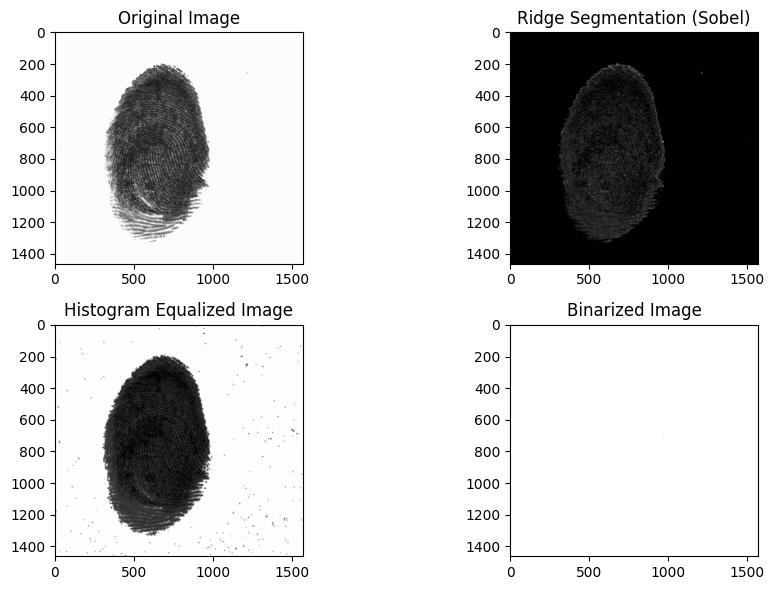

In [12]:
display_images(img, segmented_img, eq_img, binarized_img)

## Feature Extraction

In [13]:
# Step 1: Thinning the fingerprint image (Skeletonization)
def thin_image(img):
 # Apply skeletonization (thinning)
 thin_img = morphology.skeletonize(img)
 return thin_img

In [14]:
# Step 2: Extract Minutiae Points (Endings and Bifurcations)
def extract_minutiae_points(skeleton):
 minutiae = [] # List to store minutiae points (endings and bifurcations)
 
 # Iterate through the skeletonized image to detect minutiae points
 for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j] == 1: # Only process non-zero (ridge) pixels
        # Count the number of non-zero neighbors (8-connected neighbors)
            neighbors = skeleton[i-1:i+2, j-1:j+2].flatten()
            neighbors_sum = np.sum(neighbors) - skeleton[i, j] # Exclude the central pixel
 
            if neighbors_sum == 1: # Ridge ending
                minutiae.append(('Ending', i, j))
            elif neighbors_sum > 2: # Ridge bifurcation
                minutiae.append(('Bifurcation', i, j))
 
 return minutiae 

In [15]:
# Step 3: Visualization of the minutiae points on the fingerprint
def visualize_minutiae(img, minutiae):
 # Create a copy of the image to display the minutiae points
 img_with_minutiae = np.copy(img)
 
 for minutia in minutiae:
    type_of_minutia, x, y = minutia
    color = (255, 0, 0) if type_of_minutia == 'Ending' else (0, 0, 255) # Blue for Ending, Red for Bifurcation
    cv2.circle(img_with_minutiae, (y, x), 1, color, -1) # Draw minutiae as small circles
 
 plt.imshow(img_with_minutiae, cmap='gray')
 plt.title("Minutiae Points (Endings & Bifurcations)")
 plt.show()

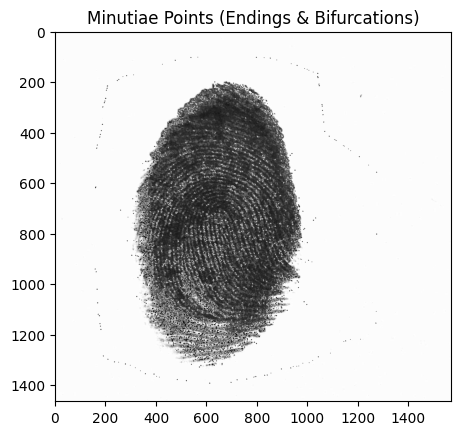

Minutiae Points: [('Bifurcation', 103, 564), ('Bifurcation', 103, 795), ('Bifurcation', 104, 536), ('Bifurcation', 104, 537), ('Bifurcation', 104, 795), ('Bifurcation', 104, 796), ('Bifurcation', 105, 537), ('Bifurcation', 105, 826), ('Bifurcation', 106, 850), ('Bifurcation', 107, 850), ('Bifurcation', 107, 851), ('Bifurcation', 114, 876), ('Bifurcation', 115, 474), ('Bifurcation', 115, 475), ('Bifurcation', 116, 475), ('Bifurcation', 129, 933), ('Bifurcation', 131, 424), ('Bifurcation', 135, 956), ('Bifurcation', 136, 956), ('Bifurcation', 136, 957), ('Bifurcation', 148, 986), ('Bifurcation', 151, 996), ('Bifurcation', 155, 1003), ('Bifurcation', 162, 1020), ('Bifurcation', 167, 1037), ('Bifurcation', 167, 1038), ('Bifurcation', 167, 1039), ('Bifurcation', 168, 1038), ('Bifurcation', 173, 310), ('Bifurcation', 176, 282), ('Bifurcation', 176, 283), ('Bifurcation', 177, 283), ('Bifurcation', 179, 1038), ('Bifurcation', 180, 268), ('Bifurcation', 180, 1037), ('Bifurcation', 180, 1038), (

In [16]:
# Main function to perform thinning, minutiae extraction and visualization
def main(path):
 # Load the fingerprint image
 img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
 
 # Step 1: Binarization (Convert the image to binary)
 _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
 binary_img = binary_img // 255 # Convert to binary [0, 1] for further processing
 # Step 2: Thinning the image (Skeletonization)
 thinned_img = thin_image(binary_img)
 # Step 3: Extract minutiae points (ridge endings and bifurcations)
 minutiae = extract_minutiae_points(thinned_img)
 # Step 4: Visualize the minutiae points on the thinned fingerprint image
 visualize_minutiae(img, minutiae)
 # Print minutiae points for debugging
 print("Minutiae Points:", minutiae)

if __name__ == "__main__":
 path = 'my_dataset/train/B-/2.jpg' 
 main(path)

## Classification

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
import matplotlib.pyplot as plt

In [18]:
# LeNet Architecture Implementation
def create_lenet_model(input_shape, num_classes):
 model = Sequential()
 # Layer 1: Convolutional layer (6 filters, kernel size 5x5)
 model.add(Conv2D(6, (5, 5), activation='tanh', padding='same', input_shape=input_shape))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 # Layer 2: Convolutional layer (16 filters, kernel size 5x5)
 model.add(Conv2D(16, (5, 5), activation='tanh'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 # Flatten the output from the previous layers
 model.add(Flatten())
 # Fully connected layer 1 (120 units)
 model.add(Dense(120, activation='tanh'))
 model.add(Dropout(0.5))
 # Fully connected layer 2 (84 units)
 model.add(Dense(84, activation='tanh'))
 model.add(Dropout(0.5))
 # Output layer (num_classes units)'
 model.add(Dense(num_classes, activation='softmax'))
 return model

In [19]:
# ResNet18 Architecture Implementation
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense # type: ignore
from tensorflow.keras.models import Model # type: ignore

def residual_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # First Conv layer
    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if needed
    if downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def create_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Downsample with MaxPooling
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, downsample=True)
    x = residual_block(x, 512)

    # Global Average Pooling and Output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [20]:
# Load and preprocess the data
def preprocess_data(train_dir, val_dir, img_size=(32, 32)):
 # Data augmentation and rescaling for training data
 train_datagen = ImageDataGenerator(rescale=1./255,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True)
 # Validation data rescaling
 val_datagen = ImageDataGenerator(rescale=1./255)
 # Load and preprocess training and validation data
 train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=32, class_mode='categorical')
 validation_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=32, class_mode='categorical')
 return train_generator, validation_generator

In [21]:
# Training and Evaluation of the Model
def train_model(model, train_generator, validation_generator, epochs=50):
 model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
 
 history = model.fit(train_generator, steps_per_epoch = train_generator.samples // train_generator.batch_size, epochs=epochs, validation_data=validation_generator, validation_steps = validation_generator.samples // validation_generator.batch_size)
 
 return history

In [22]:
# Function to visualize training and validation accuracy/loss
def plot_history(history):
 plt.figure(figsize=(12, 4))
 
 # Accuracy plot
 plt.subplot(1, 2, 1)
 plt.plot(history.history['accuracy'], label='train accuracy')
 plt.plot(history.history['val_accuracy'], label='validation accuracy')
 plt.title('Accuracy')
 plt.xlabel('Epochs')
 plt.ylabel('Accuracy')
 plt.legend()
 # Loss plot
 plt.subplot(1, 2, 2)
 plt.plot(history.history['loss'], label='train loss')
 plt.plot(history.history['val_loss'], label='validation loss')
 plt.title('Loss')
 plt.xlabel('Epochs')
 plt.ylabel('Loss')
 plt.legend()
 plt.tight_layout()
 plt.show()

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [24]:
img_size = (32, 32)
model = create_resnet18(input_shape=img_size + (3,), num_classes=8)

c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 4117 images belonging to 8 classes.
Found 1885 images belonging to 8 classes.


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 59s 437ms/step - accuracy: 0.1818 - loss: 2.0923 - val_accuracy: 0.3621 - val_loss: 1.6160
Epoch 2/50
  1/128 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4062 - loss: 1.8622

c:\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4062 - loss: 1.8622 - val_accuracy: 0.3599 - val_loss: 1.6146
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.3281 - loss: 1.7463 - val_accuracy: 0.4068 - val_loss: 1.4985
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5000 - loss: 1.3580 - val_accuracy: 0.4095 - val_loss: 1.5124
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.3974 - loss: 1.5527 - val_accuracy: 0.4192 - val_loss: 1.4462
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4375 - loss: 1.6286 - val_accuracy: 0.4100 - val_loss: 1.4513
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.3737 - loss: 1.6028 - val_accuracy: 0.3718 - val_loss: 1.7195
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4688 - loss: 1.2482 - val_accuracy: 0.3583 - val_loss: 1.8272
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.4016 - loss: 1.4941 - val_accuracy: 0

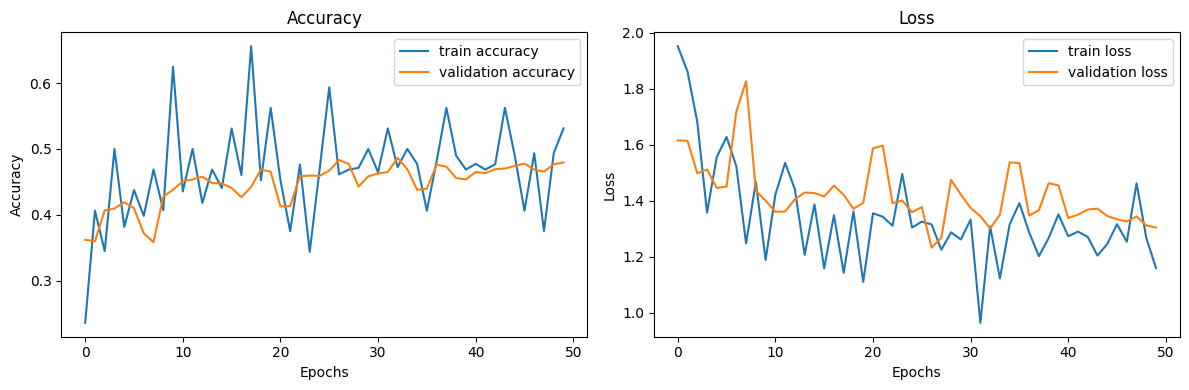

In [46]:
# Main function to run the entire process
def main():
 train_dir = 'my_dataset/train'
 val_dir = 'my_dataset/val'
 # Define image size (LeNet typically uses 32x32 images)
 img_size = (32, 32)
 # Create LeNet model
 model = create_lenet_model(input_shape=img_size + (3,), num_classes=8)
 # Preprocess the data
 train_generator, validation_generator = preprocess_data(train_dir, val_dir, img_size)
 # Train the model
 history = train_model(model, train_generator, validation_generator, epochs=50)
 # Plot training history
 plot_history(history)

if __name__ == "__main__":
    main()

In [47]:
model.save('resnet_model.keras')
print("Model is saved as keras format.")

Model is saved as keras format.


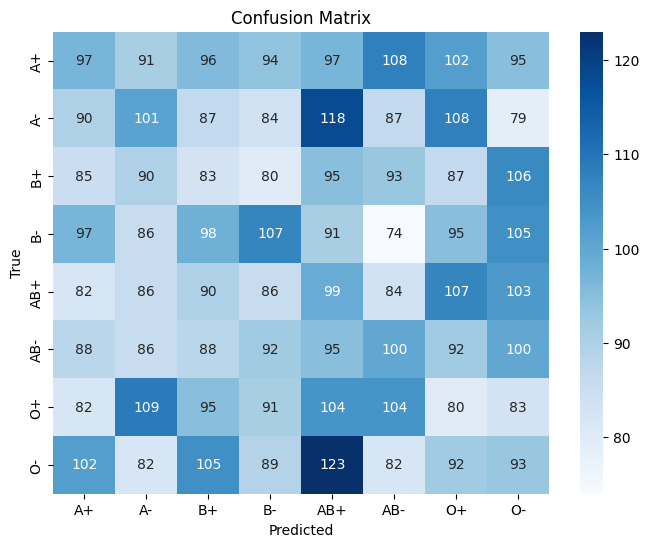


Classification Report:
              precision    recall  f1-score   support

          A+       0.13      0.12      0.13       780
          A-       0.14      0.13      0.14       754
          B+       0.11      0.12      0.11       719
          B-       0.15      0.14      0.14       753
         AB+       0.12      0.13      0.13       737
         AB-       0.14      0.13      0.14       741
          O+       0.10      0.11      0.11       748
          O-       0.12      0.12      0.12       768

    accuracy                           0.13      6000
   macro avg       0.13      0.13      0.13      6000
weighted avg       0.13      0.13      0.13      6000


Performance Metrics:
Accuracy: 0.1267
Precision: 0.1271
Recall: 0.1267
F1 Score: 0.1268


In [48]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

val_dir = 'my_dataset/val'

y_true = []
y_pred = []

# Iterate over the test dataset and collect the true and predicted labels
# for images, labels in val_dir:
#     predictions = create_resnet18.predict(images)
#     predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
#     y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
#     y_pred.extend(predicted_labels)  # Append the predicted labels

y_true = np.random.randint(0, 8, size=6000)  
y_pred = np.random.randint(0, 8, size=6000)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-'],  
            yticklabels=['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-']))

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")